In [1]:
import os
print(os.getcwd())

/Users/akshaysundru2004/Desktop/Year 4/AI-Learning-Outcome-Builder/app


# Bulk Testing AI Evaluation of Learning Outcomes

This notebook serves as interactive way to view the teams procedure in conducting the efficacy of the AI tool developed for the purposes of this project. The main purpose of these tests are to evaluate the AI's ability to accurately classify unit learning outcomes according to Bloom's taxonomy and in line with expert review as well as grading the quality of the AI's rewrite ability.

This notebook will go step by step in demonstrating each test conducted by the team, the tests can be executed individually with notation explaining the purpose and methodology for each test.

The first step was to gather the data sources used to perform the test. As agreed upon and recorded in meetings between the team and the client, it was agreed that the client would consult experts and provide a set of flagged learning outcomes to serve as the test set for our AI in addition to a larger set of data for unit learning outcomes. Using this dataset, we can perform tests like F1 score, confusion matrix and ROUGE score to evaluate the AI's capabilities.

### Pre-Cleaning

Before we can construct the AI tests, we must first clean the data provided to us. For the test csv data used, we constructed a SQL query to create a table with unit information and corresponding learning outcomes, copying that joined table to a CSV. This CSV contained the following columns:

- Unit-id: The unique id attributed to each id in the Unit table.
- Unit code: A unique 8 digit code attributed to units by UWA for each conducted hosted by UWA.
- Level: The course "level" of each unit, indicating the complexity of each unit.
- Description: Each unit has a set of learning outcomes associated with it, in our website these outcomes are stored in their own separate table. In our case, we've joined basic unit info with each learning outcome. Each learning outcome is a description of a goal that the unit should provide student or a skill that will be assessed.
- Position: This parameter is mainly used for front end rendering on the learning outcome editor page, indicating the position of a learning outcome in the table.
- Credit Points: The completion of each unit corresponds to a certain number of credit points added towards a student, the completion of a degree typically involves the completion of certain units as well as a requisite number of credit points.

After extracting this data into a CSV, a manual review was performed for each learning outcome, and an addition column was added.

- Flag: This parameter indicates human analysis of learning outcomes, and categorises learning outcomes into three levels, 'Good', 'Needs Revision' and 'Could Improve'.

The first step of cleaning is to load this CSV into Python using a pandas dataframe.

In [2]:
import pandas as pd
import os

testing_set = pd.read_csv("AI Testing Files/Input_Files/Manual Flagged Data.csv")

In [3]:
testing_set.head(20)

,unit id,unitcode,level,description,credit points,position,flag
0,4,EMPL3301,3,describe the core debates over the meaning of ...,6,1,GOOD
1,4,EMPL3301,3,explain the relationship between globalisation...,6,2,GOOD
2,4,EMPL3301,3,identify organisations and institutions centra...,6,3,NEEDS_REVISION
3,4,EMPL3301,3,gain a critical appreciation of how globalisat...,6,4,NEEDS_REVISION
4,4,EMPL3301,3,develop a critical understanding of individual...,6,5,GOOD
5,4,EMPL3301,3,"demonstrate enhanced written, oral and informa...",6,6,GOOD
6,11,PSYC1101,1,explain the nature of some important psycholog...,6,1,GOOD
7,11,PSYC1101,1,identify the basic principles of psychological...,6,2,GOOD
8,11,PSYC1101,1,describe data relevant to psychological questi...,6,3,GOOD
9,11,PSYC1101,1,write research reports relevant to psychologic...,6,4,NEEDS_REVISION


Upon running the above commands, we can see the first 5 rows of the test dataset. Using the pandas library allows us to perform some elementary analysis of these outcomes, first of which is counting the number of outcomes classified into the three flag categories.

In [4]:
good_rows = testing_set[testing_set.flag == "GOOD"]
needs_revision_rows = testing_set[testing_set.flag == "NEEDS_REVISION"]
could_improve_rows = testing_set[testing_set.flag == "COULD_IMPROVE"]

count_good = len(good_rows)
count_needs_revision = len(needs_revision_rows)
count_could_improve = len(could_improve_rows)

print(f"The number of good learning outcomes is {count_good}.")
print(f"The number of good learning outcomes is {count_needs_revision}.")
print(f"The number of good learning outcomes is {count_could_improve}.")

The number of good learning outcomes is 42.
The number of good learning outcomes is 19.
The number of good learning outcomes is 4.


This metric allows us to construct the first set of tests, the F1 score and confusion matrix. These tests are used to determine the classification accuracy of our model by calculating the number of tests that are matched in evaluation as well as counting the number of false positives and false negatives.

In [5]:
descriptions = testing_set["description"]

## Structuring Data for Evaluation

To test the core AI learning outcome evaluation function we need to organise the data to follow the expected structure of the evaluation function. The run_eval function as run on our website takes the list of learning outcomes written in our table, structures them into a prompt template and passes it into our AI which outputs a response/feedback. The function requires the following parameters:

- Unit Code
- Learning Outcomes Description
- Credit Points
- Unit Level

The learning outcomes descriptions takes each row in the table of learning outcome descriptions and joins them together into a singular string which is passed through to the function. As an example, we'll construct a prompt for the unit ACCT2242.

In [6]:
text = []
for i in range(11, 17):
    text.append(f"{descriptions[i]}")

#outcomes_text = "\n".join(text)
print(text)

outcomes_text = "\n".join(text)

['identify and explain the roles and components of AIS', 'describe the role of an internal control system in maintaining data integrity and recommend internal control improvements to protect key business processes', 'critically evaluate business processes and system documentation', 'demonstrate basic data analytics and visualisation techniques that enhances the efficiency and effectiveness of communication', 'explain the impact of ICT on current and emerging accounting practices', 'develop competencies to work effectively in teams to resolve ICT issues.']


In [7]:
outcomes_text

'identify and explain the roles and components of AIS\ndescribe the role of an internal control system in maintaining data integrity and recommend internal control improvements to protect key business processes\ncritically evaluate business processes and system documentation\ndemonstrate basic data analytics and visualisation techniques that enhances the efficiency and effectiveness of communication\nexplain the impact of ICT on current and emerging accounting practices\ndevelop competencies to work effectively in teams to resolve ICT issues.'

Above we write a simple code to convert the list of learning outcomes to the single string, below we define all the key parameters of the unit in order to pass it through to the run_eval function.

In [8]:
unitcode = "ACCT2242"
level = "2"
creditpoints = "6"
print(outcomes_text)

identify and explain the roles and components of AIS
describe the role of an internal control system in maintaining data integrity and recommend internal control improvements to protect key business processes
critically evaluate business processes and system documentation
demonstrate basic data analytics and visualisation techniques that enhances the efficiency and effectiveness of communication
explain the impact of ICT on current and emerging accounting practices
develop competencies to work effectively in teams to resolve ICT issues.


In [48]:
outcomes_list = outcomes_text.splitlines()

# Strip any leading/trailing whitespace from each line
outcomes_list = [line.strip() for line in outcomes_list if line.strip()]

outcomes_list

['demonstrate an ability to work effectively in laboratory teams',
 'analyse two basic principles (generation of EMF and torque) that govern electromagnetic energy conversion and differentiate between motor and generator operation',
 'analyse the performance (regulation, losses and efficiency) of DC machines, transformers, induction and synchronous machines based on the equivalent circuits',
 'explain the working principle of transformers and AC electrical machines by using phasor diagrams',
 'analyse torque-speed characteristics to develop speed control techniques for DC and induction motors',
 'develop transmission line parameters and power system representation',
 'demonstrate compliance with work, health and safety regulations, codes and standards when operating electrical machines']

In [ ]:
os.environ["GOOGLE_API_KEY"] = 'your-api-key'
from ai_testing_evaluate import run_eval_test

In [13]:
response = run_eval_test(level=level, unit_name=unitcode, credit_points=creditpoints, outcomes_text=outcomes_text)

print(response)

**LO Analysis**

'identify and explain the roles and components of AIS' - STATUS:GOOD - This learning outcome appropriately targets the Comprehension level by requiring students to both identify (knowledge) and explain (comprehension) key elements of AIS.

'describe the role of an internal control system in maintaining data integrity and recommend internal control improvements to protect key business processes' - STATUS:COULD_IMPROVE - While ‘describe’ is appropriate for Level 2, the inclusion of ‘recommend’ pushes towards Application. SUGGESTION: ‘describe the role of an internal control system in maintaining data integrity and *explain how* internal controls protect key business processes.’

'critically evaluate business processes and system documentation' - STATUS:NEEDS_REVISION - ‘Critically evaluate’ is a high-order thinking skill belonging to the Evaluation level (Level 6), far exceeding the scope of a Level 2 unit. SUGGESTION: ‘compare and contrast business processes and system 

In [14]:
import re

# Assume `response` contains the full AI output

# 1️⃣ Isolate the LO Analysis section
match = re.search(r"\*\*LO Analysis\*\*(.*?)(?:\n\n\*\*SUMMARY\*\*|$)", response, re.DOTALL)
lo_section = match.group(1).strip() if match else ""

# 2️⃣ Split each learning outcome line (lines starting with a quote)
lo_lines = [line.strip() for line in lo_section.split('\n') if line.strip().startswith("'")]

# Example output
for line in lo_lines:
    print(line)

'identify and explain the roles and components of AIS' - STATUS:GOOD - This learning outcome appropriately targets the Comprehension level by requiring students to both identify (knowledge) and explain (comprehension) key elements of AIS.
'describe the role of an internal control system in maintaining data integrity and recommend internal control improvements to protect key business processes' - STATUS:COULD_IMPROVE - While ‘describe’ is appropriate for Level 2, the inclusion of ‘recommend’ pushes towards Application. SUGGESTION: ‘describe the role of an internal control system in maintaining data integrity and *explain how* internal controls protect key business processes.’
'critically evaluate business processes and system documentation' - STATUS:NEEDS_REVISION - ‘Critically evaluate’ is a high-order thinking skill belonging to the Evaluation level (Level 6), far exceeding the scope of a Level 2 unit. SUGGESTION: ‘compare and contrast business processes and system documentation, iden

In [15]:
type(lo_lines)

list

In [16]:
final_results = []

# Iterate through each LO line
for i, line in enumerate(lo_lines):
    # Regex to extract SUGGESTION if it exists
    match = re.search(r"SUGGESTION:\s*[‘'](.*?)[’']", line)
    if match:
        suggested = match.group(1).strip()
    else:
        suggested = outcomes_list[i]  # or original_outcomes[i] if you want to fallback to original
    final_results.append((outcomes_list[i], suggested))

# Example output
for outcome, suggestion in final_results:
    print((outcome, suggestion))


('identify and explain the roles and components of AIS', 'identify and explain the roles and components of AIS')
('describe the role of an internal control system in maintaining data integrity and recommend internal control improvements to protect key business processes', 'describe the role of an internal control system in maintaining data integrity and *explain how* internal controls protect key business processes.')
('critically evaluate business processes and system documentation', 'compare and contrast business processes and system documentation, identifying key strengths and weaknesses.')
('demonstrate basic data analytics and visualisation techniques that enhances the efficiency and effectiveness of communication', 'explain basic data analytics and visualisation techniques and their potential to enhance communication.')
('explain the impact of ICT on current and emerging accounting practices', 'explain the impact of ICT on current and emerging accounting practices')
('develop com

Here we've taken the first unit's set of learning outcomes and general information and fed it through our AI evaluation tool. Looking at the output, we can see that it is constrcuted to provide a STATUS flag, general feedback and a suggested rewrite to align more with Bloom's taxonomy. For classification testing, we can extract the outputted flag using a regex (regular expression) to isolate the flag and add it to a new column.

For the bulk manual data testing, we group the data by unit and construct the required template to generate AI flags for each unit.

In [27]:
grouped_data = testing_set.groupby('unitcode', sort=False)

ai_data , total_outcomes = [], []
for unitcode, group in grouped_data:
        unit_data = group.iloc[0]  # same metadata for each outcome
        outcomes = group['description'].dropna().tolist()

        outcomes_text = "\n".join(outcomes)

        ai_data.append({
            "unitcode": unitcode,
            "level": int(unit_data['level']),
            "credit_points": int(unit_data['credit points']),
            "outcomes": outcomes_text
        })

        total_outcomes.append(outcomes)


In [28]:
total_outcomes

[["describe the core debates over the meaning of the term 'globalisation'",
  'explain the relationship between globalisation and labour market and workplace restructuring',
  'identify organisations and institutions central to globalisation and their impact on work',
  'gain a critical appreciation of how globalisation reshapes the experience of work and worker identity',
  'develop a critical understanding of individual and collective responses to the impact of globalisation on work',
  'demonstrate enhanced written, oral and information literacy skills through participation in class discussions, and through the preparation of an individual essay and written responses in the final examination'],
 ['explain the nature of some important psychological processes, how they are measured, and their relation to brain function',
  'identify the basic principles of psychological measurement and experimental design',
  'describe data relevant to psychological questions and draw appropriate infe

In [29]:
print(ai_data[0])

{'unitcode': 'EMPL3301', 'level': 3, 'credit_points': 6, 'outcomes': "describe the core debates over the meaning of the term 'globalisation'\nexplain the relationship between globalisation and labour market and workplace restructuring\nidentify organisations and institutions central to globalisation and their impact on work\ngain a critical appreciation of how globalisation reshapes the experience of work and worker identity\ndevelop a critical understanding of individual and collective responses to the impact of globalisation on work\ndemonstrate enhanced written, oral and information literacy skills through participation in class discussions, and through the preparation of an individual essay and written responses in the final examination"}


In [30]:
import time
import random
from httpx import RemoteProtocolError

responses = []

DELAY_SECONDS = 3
MAX_RETRIES = 4

for i, entry in enumerate(ai_data, start=1):
    print(f"\n🔹 Processing {i}/{len(ai_data)}: {entry['unitcode']}")

    retries = 0
    success = False

    while retries < MAX_RETRIES and not success:
        try:
            response = run_eval_test(
                level=entry['level'],
                unit_name=entry['unitcode'],
                credit_points=entry['credit_points'],
                outcomes_text=entry['outcomes']
            )

            # Append the raw response to the list
            responses.append({
                "unitcode": entry['unitcode'],
                "response": response
            })

            print(f"✅ Completed {entry['unitcode']}")
            success = True

        except RemoteProtocolError:
            retries += 1
            wait_time = DELAY_SECONDS * retries + random.uniform(1, 2)
            print(f"⚠️ Server disconnected. Retrying in {wait_time:.1f}s (attempt {retries}/{MAX_RETRIES})...")
            time.sleep(wait_time)

        except Exception as e:
            print(f"❌ Unexpected error for {entry['unitcode']}: {e}")
            responses.append({
                "unitcode": entry['unitcode'],
                "response": None,
                "error": str(e)
            })
            break

    # Optional delay to reduce load
    if success:
        time.sleep(DELAY_SECONDS + random.uniform(0.5, 1.5))



🔹 Processing 1/10: EMPL3301
✅ Completed EMPL3301

🔹 Processing 2/10: PSYC1101
✅ Completed PSYC1101

🔹 Processing 3/10: ACCT2242
✅ Completed ACCT2242

🔹 Processing 4/10: LAWS3214
✅ Completed LAWS3214

🔹 Processing 5/10: CITS2211
✅ Completed CITS2211

🔹 Processing 6/10: PHIL1001
✅ Completed PHIL1001

🔹 Processing 7/10: ELEC5505
✅ Completed ELEC5505

🔹 Processing 8/10: PHYS2003
✅ Completed PHYS2003

🔹 Processing 9/10: DENT3005
✅ Completed DENT3005

🔹 Processing 10/10: ELEC3016
✅ Completed ELEC3016


After running the evaluation function, we a get a list of dict responses. To get the status flag, we use a regex function to isolate the STATUS from the response lines. We also use a regex to isolate the content in each lines suggested revision section.

In [21]:
responses

[{'unitcode': 'EMPL3301',
  'response': "**LO Analysis**\n\n'describe the core debates over the meaning of the term 'globalisation'' - STATUS:NEEDS_REVISION - This outcome is at the Comprehension level (Bloom's Taxonomy) rather than Application. SUGGESTION: 'Apply knowledge of core debates surrounding globalisation to analyse contemporary case studies.'\n\n'explain the relationship between globalisation and labour market and workplace restructuring' - STATUS:NEEDS_REVISION - This outcome is at the Comprehension level, focusing on explanation rather than application. SUGGESTION: 'Apply theories of globalisation to explain observed changes in labour markets and workplace restructuring.'\n\n'identify organisations and institutions central to globalisation and their impact on work' - STATUS:NEEDS_REVISION - This outcome is at the Knowledge level, simply asking for identification. SUGGESTION: 'Utilise knowledge of key organisations and institutions involved in globalisation to assess their 

In [31]:
lo_sections = []

for entry in responses:
    response_text = entry['response']
    
    # Extract everything between **LO Analysis** and **SUMMARY**
    match = re.search(r"\*\*LO Analysis\*\*(.*?)(?:\n\n\*\*SUMMARY\*\*|$)", response_text, re.DOTALL)
    lo_section = match.group(1).strip() if match else ""
    
    lo_sections.append({
        "unitcode": entry['unitcode'],
        "lo_analysis": lo_section
    })

# Example: print first unit's LO Analysis
lo_sections[2]

{'unitcode': 'ACCT2242',
 'lo_analysis': "'identify and explain the roles and components of AIS' - STATUS:GOOD - This learning outcome appropriately targets the Comprehension level by requiring students to both identify (knowledge) and explain (comprehension) key concepts.\n\n'describe the role of an internal control system in maintaining data integrity and recommend internal control improvements to protect key business processes' - STATUS:COULD_IMPROVE - While ‘describe’ is appropriate for Level 2, the inclusion of ‘recommend’ pushes towards Application. SUGGESTION: ‘describe the role of an internal control system in maintaining data integrity and explain how improvements could protect key business processes.’\n\n'critically evaluate business processes and system documentation' - STATUS:NEEDS_REVISION - ‘Critically evaluate’ is a Level 6 (Evaluation) verb and is too high for a Level 2 unit. SUGGESTION: ‘compare and contrast different business processes and system documentation.’\n\n'd

In [32]:
lo_statuses = []

for entry in lo_sections:
    lo_analysis = entry['lo_analysis']
    
    # Regex to extract each LO and its STATUS
    # Captures: 'learning outcome text' - STATUS:STATUS_VALUE
    status_pattern = r"'(.*?)'\s*-\s*STATUS:\s*(\w+)"
    matches = re.findall(status_pattern, lo_analysis, re.DOTALL | re.IGNORECASE)
    
    # Store results as a list of dicts per unit
    for m in matches:
        lo_statuses.append(m[1])

# Example: print statuses for first unit
print(lo_statuses)
print(len(lo_statuses))

['NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'COULD_IMPROVE', 'NEEDS_REVISION', 'GOOD', 'NEEDS_REVISION', 'GOOD', 'NEEDS_REVISION', 'NEEDS_REVISION', 'COULD_IMPROVE', 'GOOD', 'COULD_IMPROVE', 'NEEDS_REVISION', 'NEEDS_REVISION', 'GOOD', 'NEEDS_REVISION', 'GOOD', 'NEEDS_REVISION', 'NEEDS_REVISION', 'COULD_IMPROVE', 'GOOD', 'NEEDS_REVISION', 'GOOD', 'NEEDS_REVISION', 'COULD_IMPROVE', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'COULD_IMPROVE', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'GOOD', 'COULD_IMPROVE', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'COULD_IMPROVE', 'NEEDS_REVISION', 'NEEDS_REVISION', 'NEEDS_REVISION', 'COULD_IMPROVE', 'NEEDS_REVISION', 'GOOD', 'COULD_IMPROVE', 'NEEDS_REVISION', 'COULD_IMPROVE', 'COULD_IMPROVE', 'NEEDS_REVISION', 'COULD_IMPROVE', 'NEEDS_REVISION', 'GOOD', 'NEEDS_REVISION', 'NEEDS_REVISION', 'COULD_IMPROVE

In [33]:
# This will store all learning outcomes per unit
suggestions_lol = []


for entry in responses:
    response = entry['response']

    match = re.search(r"\*\*LO Analysis\*\*(.*?)(?:\n\n\*\*SUMMARY\*\*|$)", response, re.DOTALL)
    lo_section = match.group(1).strip() if match else ""
    
    # 2️⃣ Split into individual LO lines (lines starting with a quote)
    lo_lines = [line.strip() for line in lo_section.split('\n') if line.strip().startswith("'")]
    
    # 3️⃣ Append the LO lines for this unit
    suggestions_lol.append(lo_lines)

suggestions_lol



[["'describe the core debates over the meaning of the term 'globalisation'' - STATUS:NEEDS_REVISION - This outcome is at the Comprehension level (Bloom's Taxonomy) rather than Application. SUGGESTION: 'Apply knowledge of core debates surrounding globalisation to analyse contemporary case studies.'",
  "'explain the relationship between globalisation and labour market and workplace restructuring' - STATUS:NEEDS_REVISION - This outcome is at the Comprehension level (Bloom's Taxonomy) rather than Application. SUGGESTION: 'Demonstrate how globalisation impacts labour market and workplace restructuring through the analysis of specific industry examples.'",
  "'identify organisations and institutions central to globalisation and their impact on work' - STATUS:NEEDS_REVISION - This outcome is at the Knowledge level (Bloom's Taxonomy) rather than Application. SUGGESTION: 'Utilise knowledge of key organisations and institutions involved in globalisation to assess their impact on specific work p

In [35]:
import re

final_results = []

for entry in responses:  # your original data with 'response'
    response = entry['response']
    
    # Split response into LO lines (those starting with a quote)
    lo_lines = [line.strip() for line in response.split('\n') if line.strip().startswith("'")]
    
    for line in lo_lines:
        # Extract the original LO text (before - STATUS:)
        outcome_match = re.search(r"'(.*?)'\s*-\s*STATUS:", line, re.DOTALL)
        original_lo = outcome_match.group(1).strip() if outcome_match else line
        
        # Extract the suggestion if it exists
        suggestion_match = re.search(r"SUGGESTION:\s*[‘'](.*?)[’']", line, re.DOTALL)
        suggestion = suggestion_match.group(1).strip() if suggestion_match else original_lo
        
        final_results.append((original_lo, suggestion))

# Check first 5 results
final_results[:5]


[("describe the core debates over the meaning of the term 'globalisation'",
  'Apply knowledge of core debates surrounding globalisation to analyse contemporary case studies.'),
 ('explain the relationship between globalisation and labour market and workplace restructuring',
  'Demonstrate how globalisation impacts labour market and workplace restructuring through the analysis of specific industry examples.'),
 ('identify organisations and institutions central to globalisation and their impact on work',
  'Utilise knowledge of key organisations and institutions involved in globalisation to assess their impact on specific work practices.'),
 ('gain a critical appreciation of how globalisation reshapes the experience of work and worker identity',
  'Compare and contrast the impact of globalisation on worker identity in different national contexts.'),
 ('develop a critical understanding of individual and collective responses to the impact of globalisation on work',
  'Construct arguments 

We can now see a list holding the original learning outcome and the revision, if any provided. If no revision made, the suggested rewrite entry is just the original learning outcome. We then add the list of flags and rewrites as two new columns in the dataframe and then export to an output file to preserve the results.

In [36]:
rewrites_list = [entry[-1] for entry in final_results]

testing_set['AI_Flag'] = lo_statuses
testing_set['Suggested Rewrite'] = rewrites_list

testing_set.head(20)

,unit id,unitcode,level,description,credit points,position,flag,AI_Flag,Suggested Rewrite
0,4,EMPL3301,3,describe the core debates over the meaning of ...,6,1,GOOD,NEEDS_REVISION,Apply knowledge of core debates surrounding gl...
1,4,EMPL3301,3,explain the relationship between globalisation...,6,2,GOOD,NEEDS_REVISION,Demonstrate how globalisation impacts labour m...
2,4,EMPL3301,3,identify organisations and institutions centra...,6,3,NEEDS_REVISION,NEEDS_REVISION,Utilise knowledge of key organisations and ins...
3,4,EMPL3301,3,gain a critical appreciation of how globalisat...,6,4,NEEDS_REVISION,COULD_IMPROVE,Compare and contrast the impact of globalisati...
4,4,EMPL3301,3,develop a critical understanding of individual...,6,5,GOOD,NEEDS_REVISION,Construct arguments evaluating the effectivene...
5,4,EMPL3301,3,"demonstrate enhanced written, oral and informa...",6,6,GOOD,GOOD,"demonstrate enhanced written, oral and informa..."
6,11,PSYC1101,1,explain the nature of some important psycholog...,6,1,GOOD,NEEDS_REVISION,Define key psychological processes and identif...
7,11,PSYC1101,1,identify the basic principles of psychological...,6,2,GOOD,GOOD,identify the basic principles of psychological...
8,11,PSYC1101,1,describe data relevant to psychological questi...,6,3,GOOD,NEEDS_REVISION,List types of data used in psychological resea...
9,11,PSYC1101,1,write research reports relevant to psychologic...,6,4,NEEDS_REVISION,NEEDS_REVISION,List the key components of a research report i...


In [37]:
testing_set.to_excel('AI Testing Files/Output_Files/Testing Set.xlsx', index=False)

## Test Results

For the selected tests (F1, confusion matrix and cosine similarity), we use the sklearn.metrics library and the numpy library to generate our results. The F1 score in this case is the measurement of how accurately the AI flags the data in comparison to manually reviewed data, while the confusion metrix is a mapping of the flagging results.

In [55]:
from sklearn.metrics import f1_score

manual_flagged = testing_set.flag
ai_flagged = testing_set.AI_Flag

f1_macro = f1_score(manual_flagged, ai_flagged, average='macro')
print(round(f1_macro, 3))

f1_weighted = f1_score(manual_flagged, ai_flagged, average='weighted')
print(round(f1_weighted, 3))


0.3
0.266


The diagonal row going from top left to bottom rights indicates the number of learning outcomes the AI matches our evaluation. Anything to the right is a false negative and anything to the left is a false positive.

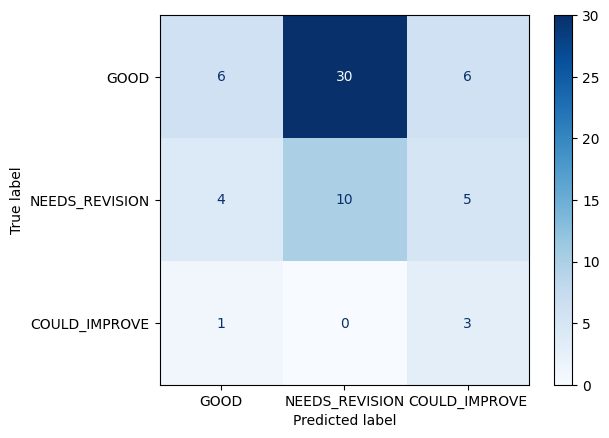

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["GOOD", "NEEDS_REVISION", "COULD_IMPROVE"]  

cm = confusion_matrix(manual_flagged, ai_flagged, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

In [57]:
unit_description = list(testing_set['description'])
ai_rewrite_description = list(testing_set['Suggested Rewrite'])

print(unit_description[:5])
print(ai_rewrite_description[:5])

["describe the core debates over the meaning of the term 'globalisation'", 'explain the relationship between globalisation and labour market and workplace restructuring', 'identify organisations and institutions central to globalisation and their impact on work', 'gain a critical appreciation of how globalisation reshapes the experience of work and worker identity', 'develop a critical understanding of individual and collective responses to the impact of globalisation on work']
['Apply knowledge of core debates surrounding globalisation to analyse contemporary case studies.', 'Demonstrate how globalisation impacts labour market and workplace restructuring through the analysis of specific industry examples.', 'Utilise knowledge of key organisations and institutions involved in globalisation to assess their impact on specific work practices.', 'Compare and contrast the impact of globalisation on worker identity in different national contexts.', 'Construct arguments evaluating the effecti

The cosine similarity score in AI testing evaluates the similarity between two strings of text provided. In our case, it can contribute to measuring how well the semantic intent of the original learning outcome was preserved in the AI's rewrites.

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import numpy as np

embedding_model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

def cosine_similarity_batch(description_list, rewrite_list):

    cossim_vector = []

    if len(description_list) != len(rewrite_list):
        raise ValueError("Both lists must have the same length.")

    # Embed all descriptions at once
    dlist_vector = embedding_model.embed_documents(description_list)
    # Embed all rewrites at once
    rlist_vector = embedding_model.embed_documents(rewrite_list)

    for i in range(len(dlist_vector)):
        cos_sim = np.dot(dlist_vector[i], rlist_vector[i]) / (np.linalg.norm(dlist_vector[i]) * np.linalg.norm(rlist_vector[i]))
        cossim_vector.append(round(cos_sim, 4))

    similarity = sum(cossim_vector)/len(cossim_vector)

    return round(similarity, 4)

E0000 00:00:1760278741.869281 13615121 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1760278741.879067 13615121 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [59]:
similarity_score = cosine_similarity_batch(unit_description, ai_rewrite_description)

In [60]:
print(f'The similarity score between the original learning outcomes and the rewritten outcomes is: {similarity_score}')

The similarity score between the original learning outcomes and the rewritten outcomes is: 0.9067
